<a href="https://colab.research.google.com/github/Rahul711sharma/News-Topic-Modeling-NLP/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, tech, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

##**Libraries**

In [209]:
!pip install spacy
!pip install scattertext

     |████████████████████████████████| 7.3MB 5.3MB/s 
     |████████████████████████████████| 23.9MB 130kB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9309 sha256=75fc78ad6c6ea4a9c23176857ede3ab30be63313b4162e5d4078bdcb435cf118
  Stored in directory: /root/.cache/pip/wheels/37/db/d7/fe74f7cb8e5c3afed90fe6f4967c933a6f13d81ab6b3d3128c
Successfully built flashtext
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import glob
import plotly.express as px

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') 
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import Data**




In [4]:
path ="/content/drive/MyDrive/Almabetter/bbc/"

In [5]:
#Importing text file paths
business = glob.glob(path+'/business/*')
entertainment = glob.glob(path+'/entertainment/*')
politics = glob.glob(path+'/politics/*')
sports = glob.glob(path+'/sport/*')
tech = glob.glob(path+'/tech/*')

In [6]:
business[0:5]

['/content/drive/MyDrive/Almabetter/bbc//business/015.txt',
 '/content/drive/MyDrive/Almabetter/bbc//business/020.txt',
 '/content/drive/MyDrive/Almabetter/bbc//business/007.txt',
 '/content/drive/MyDrive/Almabetter/bbc//business/025.txt',
 '/content/drive/MyDrive/Almabetter/bbc//business/004.txt']

In [7]:
len(business)

510

In [8]:
def make_list(data):
    list = []
    for x in range(len(data)):
      file = open(data[x],'r')
      list.append(file.read())
    return(list)

In [9]:
business_texts= make_list(business)
entertainment_text = make_list(entertainment)
politics_texts= make_list(politics)

In [10]:
sports_text=[]
try:
  for i in range(len(sports)):
    f=open(sports[i],errors='ignore')
    a=f.read()
    sports_text.append(a)
except:
  print('List ended !!')

tech_text = make_list(tech)

In [11]:
#Number of documents in every topics
print(len(business_texts),len(entertainment_text),len(politics_texts),len(sports_text),len(tech_text))

510 386 417 511 401


##**Functions For Text Cleaning and Analysis**

In [12]:
#Data Cleaning 
# We did not clear punctuations because they will help in sentence analysis
def text_processing(data):
  data = data.map(lambda x: x.replace('\n',' '))
  data = data.map(lambda x: x.lower())
  # data = data.map(lambda x: ''.join([i for i in x if i not in string.punctuation]))
  data = data.map(lambda x: ' '.join([i for i in x.split(' ') if i not in stopwords.words('english')]))
  return data

In [13]:
def number_of_sentences(data):

  data['Number of sentences'] = [len(i) for i in data['Texts'].apply(nltk.sent_tokenize)]
  return data.head()

In [14]:
#remove punctuation
def remove_punctuation(data):
  data['Texts'] = data['Texts'].map(lambda x: ''.join([i for i in x if i not in string.punctuation]))
  return data.head(2)

In [15]:
# number of words in a document 

def number_of_words(data):
  words_count = [len(i.split()) for i in data['Texts']]
  data['Number of words'] = words_count
  return data.head()

In [16]:
# Number of Complex words in document
# Complex words are defined by the length of a word greater than 4

def count_complex_words(data):
  count_complex_words = []
  for i in data['Texts']:
    count = 0
    for j in range(len(i.split())):
      if len(i.split()[j])>4:
        count+=1
      if j == len(i.split())-1:
        count_complex_words.append(count)
  data['Number of Complex words'] = count_complex_words
  return data.head()

In [17]:
# Average length of sentences
def average_len_sentence(data):

  data['Average Length of sentence'] = np.int64(data['Number of words']/data['Number of sentences'])
  return (data.head())

In [18]:
#lemmetization of words in document
def lemmatize(data):
  lemmatizer = WordNetLemmatizer()
  data['Texts'] = data['Texts'].map(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x.split()]))
  return data['Texts'][0]

In [19]:
def words_count(data):
  count = []
  word = [] 
  all_words = ' '.join(data['Texts']).split()
  for i in set(all_words):
    word.append(i)
    count.append(all_words.count(i))
  word_count_df = pd.DataFrame({'Words': word,'Frequency':count},columns=['Words','Frequency']).sort_values(by='Frequency', ascending=False)
  return word_count_df

## **Analysis Of Business Articles**

In [20]:
business = pd.DataFrame({'Texts': business_texts})
business.head()

,Texts
0,Air passengers win new EU rights\n\nAir passen...
1,Call centre users 'lose patience'\n\nCustomers...
2,Jobs growth still slow in the US\n\nThe US cre...
3,Yukos loses US bankruptcy battle\n\nA judge ha...
4,High fuel prices hit BA's profits\n\nBritish A...


In [21]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [22]:
business['Texts']= text_processing(business['Texts'])

In [23]:
number_of_sentences(business)

,Texts,Number of sentences
0,air passengers win new eu rights air passenge...,28
1,call centre users 'lose patience' customers t...,29
2,jobs growth still slow us us created fewer jo...,12
3,yukos loses us bankruptcy battle judge dismis...,23
4,high fuel prices hit ba's profits british air...,19


In [24]:
business['Number of sentences'].nlargest(15)

219    48
156    45
273    44
279    42
361    42
324    40
212    38
220    37
189    36
210    34
353    34
253    33
255    32
256    31
345    31
Name: Number of sentences, dtype: int64

In [25]:
remove_punctuation(business)

,Texts,Number of sentences
0,air passengers win new eu rights air passenge...,28
1,call centre users lose patience customers try...,29


In [26]:
number_of_words(business)

,Texts,Number of sentences,Number of words
0,air passengers win new eu rights air passenge...,28,363
1,call centre users lose patience customers try...,29,377
2,jobs growth still slow us us created fewer jo...,12,177
3,yukos loses us bankruptcy battle judge dismis...,23,267
4,high fuel prices hit bas profits british airw...,19,269


In [27]:
count_complex_words(business)

,Texts,Number of sentences,Number of words,Number of Complex words
0,air passengers win new eu rights air passenge...,28,363,280
1,call centre users lose patience customers try...,29,377,256
2,jobs growth still slow us us created fewer jo...,12,177,121
3,yukos loses us bankruptcy battle judge dismis...,23,267,206
4,high fuel prices hit bas profits british airw...,19,269,173


In [28]:
average_len_sentence(business)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence
0,air passengers win new eu rights air passenge...,28,363,280,12
1,call centre users lose patience customers try...,29,377,256,13
2,jobs growth still slow us us created fewer jo...,12,177,121,14
3,yukos loses us bankruptcy battle judge dismis...,23,267,206,11
4,high fuel prices hit bas profits british airw...,19,269,173,14


In [29]:
lemmatize(business)

'air passenger win new eu right air passenger unable board flight overbooking cancellation flight delay demand greater compensation new eu rule set compensation 250 euro £173 600 euro depending length flight new rule apply scheduled charter flight including budget airline airline attacked legislation saying could forced push price higher cover extra cost european commission facing two legal challenge one european lowfare airline association elaa international air transport association iata attacked package bad piece legislation previously passenger could claim 150 euro 300 euro stopped boarding however scheduled flight operator obliged offer compensation case overbooking offer compensation flight cancellation eu decided increase passenger compensation bid deter airline deliberately overbooking flight overbooking often lead bumping passenger moved later flight happens passenger will airline offer compensation addition flight cancelled delayed two hour fault airline passenger must paid c

In [30]:
words_count_business = words_count(business)
words_count_business[1:30]

,Words,Frequency
8628,year,884
3614,u,801
3647,company,627
4962,mr,603
6467,firm,555
6396,market,520
5043,would,463
3883,also,440
10094,new,416
7080,sale,414


In [31]:
px.bar(words_count_business[1:100],'Words','Frequency')

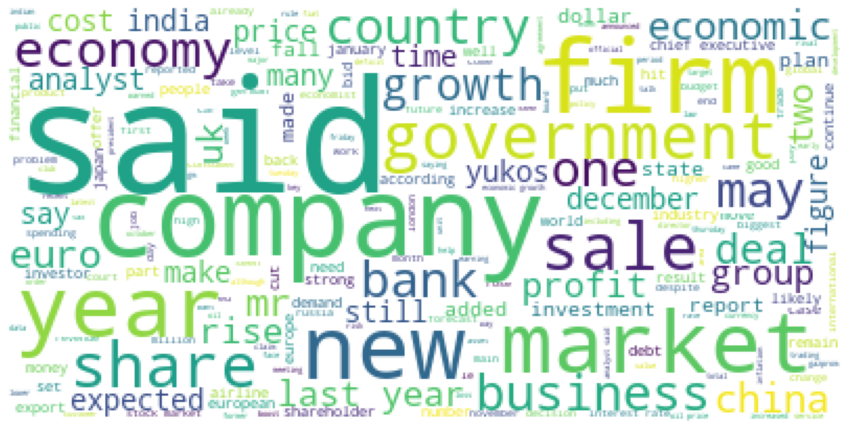

In [32]:
plt.figure(figsize=(15,15))
wordcloud = WordCloud(background_color="white").generate(' '.join(list(business['Texts'])))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

###**ADVANCED AND SEMANTIC ANALYSIS**

For Semantic Analysis I used the master semantic dictionary provided at https://sraf.nd.edu/textual-analysis/resources/ 

It has some good dictionaries such as,
Negative words,
Positive words,
Uncertainty word,
etc.

In [33]:
semantics = ['Negative','Positive','Uncertainty','Litigious','Constraining']
dictionary = dict()
for i in semantics:
  df = pd.read_excel("/content/drive/MyDrive/Almabetter/LoughranMcDonald_SentimentWordLists_2018.xlsx",sheet_name=i)
  df.iloc[0,0] = list(df.columns)[0]
  df = list(df.iloc[:,0])
  print(i,len(df))
  dictionary.update({i:df}) 
dictionary['Negative'][1:5]

Negative 2354
Positive 353
Uncertainty 296
Litigious 903
Constraining 183


['ABANDONING', 'ABANDONMENT', 'ABANDONMENTS', 'ABANDONS']

In [34]:
# Lowercasing all the sementics
for i in semantics:
  for x in range(len(dictionary[i])):
    dictionary[i][x] = dictionary[i][x].lower()

In [35]:
def semantics_analysis(data):
  semantics = ['Negative','Positive','Uncertainty','Litigious','Constraining']
  for i in semantics:
      data[i] = [len(set(data['Texts'][x].split()).intersection(dictionary[i])) for x in range(len(data['Texts']))]
      
  return data.head()

In [36]:
semantics_analysis(business)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining
0,air passenger win new eu right air passenger u...,28,363,280,12,20,5,4,3,3
1,call centre user lose patience customer trying...,29,377,256,13,13,4,5,0,0
2,job growth still slow u u created fewer job ex...,12,177,121,14,2,6,3,0,0
3,yukos loses u bankruptcy battle judge dismisse...,23,267,206,11,21,3,4,8,2
4,high fuel price hit ba profit british airway b...,19,269,173,14,4,6,2,0,0


**Polarity Score**: This is the score that determines if a given text is positive or negative in nature. It is calculated by using the formula: 

Polarity Score = **(Positive Score – Negative Score)/ (Positive Score + Negative Score) + 0.000001)**

*Range is from -1 to +1*

In [37]:
def polarity_score(business):
  business['Polarity Score'] = (business['Positive']-business['Negative'])/(business['Positive']+business['Negative'])+0.000001
  return business.head()

In [38]:
polarity_score(business)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining,Polarity Score
0,air passenger win new eu right air passenger u...,28,363,280,12,20,5,4,3,3,-0.599999
1,call centre user lose patience customer trying...,29,377,256,13,13,4,5,0,0,-0.529411
2,job growth still slow u u created fewer job ex...,12,177,121,14,2,6,3,0,0,0.500001
3,yukos loses u bankruptcy battle judge dismisse...,23,267,206,11,21,3,4,8,2,-0.749999
4,high fuel price hit ba profit british airway b...,19,269,173,14,4,6,2,0,0,0.200001


Even by just looking at the proportion of negative to positive words in the document we are able to deduce the sentiment of the texts.


## **ANALYSIS OF ENTERTAINMENT ARTICLES**

In [39]:
entertainment = pd.DataFrame({'Texts': entertainment_text})
entertainment.head()

,Texts
0,Poppins musical gets flying start\n\nThe stage...
1,Levy tipped for Whitbread prize\n\nNovelist An...
2,UK's National Gallery in the pink\n\nThe Natio...
3,Vera Drake scoops film award\n\nOscar hopefuls...
4,Adventure tale tops awards\n\nYoung book fans ...


In [40]:
entertainment['Texts']= text_processing(entertainment['Texts'])

In [41]:
number_of_sentences(entertainment)

,Texts,Number of sentences
0,poppins musical gets flying start stage adapt...,9
1,levy tipped whitbread prize novelist andrea l...,17
2,"uk's national gallery pink national gallery, ...",15
3,vera drake scoops film award oscar hopefuls m...,13
4,adventure tale tops awards young book fans vo...,11


In [42]:
entertainment['Number of sentences'].nlargest(15)

276    229
251    137
336    134
142     64
380     51
318     48
231     45
290     43
46      42
243     41
170     36
174     35
304     35
311     35
15      34
Name: Number of sentences, dtype: int64

In [43]:
remove_punctuation(entertainment)

,Texts,Number of sentences
0,poppins musical gets flying start stage adapt...,9
1,levy tipped whitbread prize novelist andrea l...,17


In [44]:
number_of_words(entertainment)

,Texts,Number of sentences,Number of words
0,poppins musical gets flying start stage adapt...,9,116
1,levy tipped whitbread prize novelist andrea l...,17,216
2,uks national gallery pink national gallery ho...,15,222
3,vera drake scoops film award oscar hopefuls m...,13,197
4,adventure tale tops awards young book fans vo...,11,152


In [45]:
count_complex_words(entertainment)

,Texts,Number of sentences,Number of words,Number of Complex words
0,poppins musical gets flying start stage adapt...,9,116,92
1,levy tipped whitbread prize novelist andrea l...,17,216,167
2,uks national gallery pink national gallery ho...,15,222,164
3,vera drake scoops film award oscar hopefuls m...,13,197,148
4,adventure tale tops awards young book fans vo...,11,152,105


In [46]:
average_len_sentence(entertainment)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence
0,poppins musical gets flying start stage adapt...,9,116,92,12
1,levy tipped whitbread prize novelist andrea l...,17,216,167,12
2,uks national gallery pink national gallery ho...,15,222,164,14
3,vera drake scoops film award oscar hopefuls m...,13,197,148,15
4,adventure tale tops awards young book fans vo...,11,152,105,13


In [47]:
lemmatize(entertainment)

'poppins musical get flying start stage adaptation childrens film mary poppins opening night london west end sir cameron mackintosh lavish production cost £9m bring stage given 10minute standing ovation lead actress laura michelle kelly soared head audience holding nanny trademark umbrella technical hitch prevented mary poppins flight auditorium preview performance number celebrity turned musical premiere including actress barbara windsor comic graham norton sir richard attenborough show director richard eyre issued warning earlier week show unsuitable child seven underthrees barred mary poppins originally created author pamela travers said cried saw disney 1964 film starring julie andrew travers intended story lot darker perennial family favourite theatre impresario sir cameron mackintosh said hope musical blend sweetnatured film original book'

In [48]:
words_count_entertainment = words_count(entertainment)
words_count_entertainment[1:30]

,Words,Frequency
7107,said,825
8227,year,594
6169,best,590
5896,award,506
8846,music,435
353,show,404
3723,also,398
9664,one,371
3471,u,369
5491,star,328


In [49]:
px.bar(words_count_entertainment[1:100],'Words','Frequency')

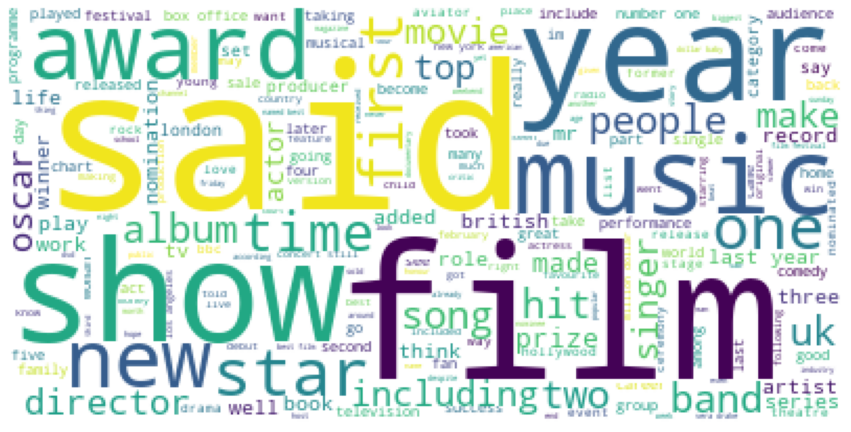

In [50]:
plt.figure(figsize=(15,15))
wordcloud = WordCloud(background_color="white").generate(' '.join(list(entertainment['Texts'])))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [51]:
semantics_analysis(entertainment)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining
0,poppins musical get flying start stage adaptat...,9,116,92,12,3,1,0,0,1
1,levy tipped whitbread prize novelist andrea le...,17,216,167,12,3,6,1,0,0
2,uk national gallery pink national gallery home...,15,222,164,14,0,10,1,1,0
3,vera drake scoop film award oscar hopeful mike...,13,197,148,15,0,5,0,0,0
4,adventure tale top award young book fan voted ...,11,152,105,13,0,5,1,0,0


In [52]:
polarity_score(entertainment)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining,Polarity Score
0,poppins musical get flying start stage adaptat...,9,116,92,12,3,1,0,0,1,-0.499999
1,levy tipped whitbread prize novelist andrea le...,17,216,167,12,3,6,1,0,0,0.333334
2,uk national gallery pink national gallery home...,15,222,164,14,0,10,1,1,0,1.000001
3,vera drake scoop film award oscar hopeful mike...,13,197,148,15,0,5,0,0,0,1.000001
4,adventure tale top award young book fan voted ...,11,152,105,13,0,5,1,0,0,1.000001


##**ANALYSIS OF POLITICS ARTICLES**

In [54]:
politics = pd.DataFrame({'Texts': politics_texts})
politics.head()

,Texts
0,Howard rebuts asylum criticisms\n\nTory leader...
1,Mrs Howard gets key election role\n\nMichael H...
2,Hewitt decries 'career sexism'\n\nPlans to ext...
3,'Errors' doomed first Dome sale\n\nThe initial...
4,Labour chooses Manchester\n\nThe Labour Party ...


In [55]:
politics['Texts']= text_processing(politics['Texts'])

In [56]:
number_of_sentences(politics)

,Texts,Number of sentences
0,howard rebuts asylum criticisms tory leader m...,25
1,mrs howard gets key election role michael how...,16
2,hewitt decries 'career sexism' plans extend p...,26
3,'errors' doomed first dome sale initial attem...,15
4,labour chooses manchester labour party hold 2...,12


In [57]:
politics['Number of sentences'].nlargest(15)

293    242
391    148
317    134
191     79
139     53
251     49
357     41
304     39
401     38
244     37
224     36
229     35
408     34
347     33
376     33
Name: Number of sentences, dtype: int64

In [58]:
remove_punctuation(politics)

,Texts,Number of sentences
0,howard rebuts asylum criticisms tory leader m...,25
1,mrs howard gets key election role michael how...,16


In [59]:
number_of_words(politics)

,Texts,Number of sentences,Number of words
0,howard rebuts asylum criticisms tory leader m...,25,333
1,mrs howard gets key election role michael how...,16,177
2,hewitt decries career sexism plans extend pai...,26,310
3,errors doomed first dome sale initial attempt...,15,200
4,labour chooses manchester labour party hold 2...,12,141


In [60]:
count_complex_words(politics)

,Texts,Number of sentences,Number of words,Number of Complex words
0,howard rebuts asylum criticisms tory leader m...,25,333,221
1,mrs howard gets key election role michael how...,16,177,110
2,hewitt decries career sexism plans extend pai...,26,310,205
3,errors doomed first dome sale initial attempt...,15,200,132
4,labour chooses manchester labour party hold 2...,12,141,102


In [61]:
average_len_sentence(politics)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence
0,howard rebuts asylum criticisms tory leader m...,25,333,221,13
1,mrs howard gets key election role michael how...,16,177,110,11
2,hewitt decries career sexism plans extend pai...,26,310,205,11
3,errors doomed first dome sale initial attempt...,15,200,132,13
4,labour chooses manchester labour party hold 2...,12,141,102,11


In [62]:
lemmatize(politics)

'howard rebuts asylum criticism tory leader michael howard gone offensive response people questioning son immigrant propose asylum quota mr howard whose parent fled nazi threat come uk say claim would mean noone immigrant family could become premier comment come bbc documentary called no mr nasty tv presenter anne robinson said home secretary gave impression would like kick cat m robinson friend tory leader also revealed cambridge student mr howard much loved woman courteous kind rather dashing lover although denied personal experience i cambridge personal experience know people were documentary maker michael cockerell given behindthescenes access mr howard film portrait tory leader asked respond people said quota immigration asylum 1930s parent might allowed country reply what inference that that reach view need control immigration interest country allowed put view forward happen descended immigrant that seems absolutely extraordinary proposition would certainly mean one immigrant par

In [64]:
words_count_politics = words_count(politics)
words_count_politics[1:30]

,Words,Frequency
4346,mr,1718
4420,would,1051
8504,labour,760
1408,government,742
7460,party,707
6568,election,629
7408,people,623
2475,blair,573
4214,minister,565
4820,tory,510


In [65]:
px.bar(words_count_politics[1:100],'Words','Frequency')

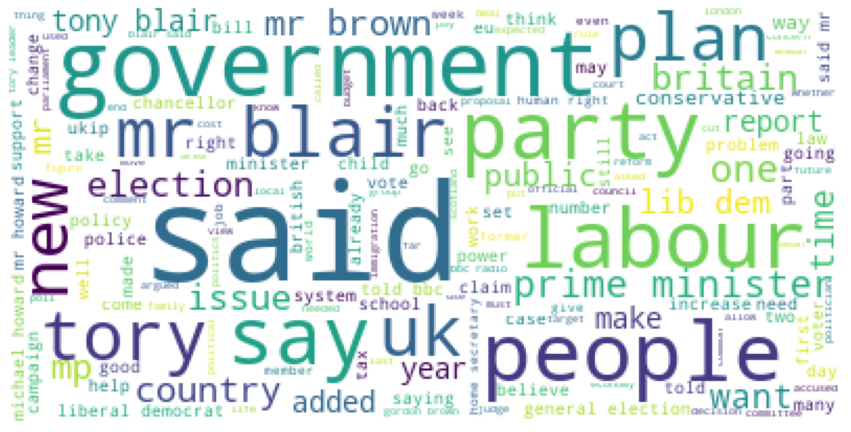

In [66]:
plt.figure(figsize=(15,15))
wordcloud = WordCloud(background_color="white").generate(' '.join(list(politics['Texts'])))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [67]:
semantics_analysis(politics)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining
0,howard rebuts asylum criticism tory leader mic...,25,333,221,13,12,7,6,3,0
1,mr howard get key election role michael howard...,16,177,110,11,2,1,2,0,0
2,hewitt decries career sexism plan extend paid ...,26,310,205,11,7,3,2,1,3
3,error doomed first dome sale initial attempt s...,15,200,132,13,9,5,3,0,0
4,labour chooses manchester labour party hold 20...,12,141,102,11,3,0,0,1,0


In [68]:
polarity_score(politics)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining,Polarity Score
0,howard rebuts asylum criticism tory leader mic...,25,333,221,13,12,7,6,3,0,-0.263157
1,mr howard get key election role michael howard...,16,177,110,11,2,1,2,0,0,-0.333332
2,hewitt decries career sexism plan extend paid ...,26,310,205,11,7,3,2,1,3,-0.399999
3,error doomed first dome sale initial attempt s...,15,200,132,13,9,5,3,0,0,-0.285713
4,labour chooses manchester labour party hold 20...,12,141,102,11,3,0,0,1,0,-0.999999


##**ANALYSIS OF SPORTS ARTICLES**

In [69]:
sport = pd.DataFrame({'Texts': sports_text})
sport.head()

,Texts
0,London hope over Chepkemei\n\nLondon Marathon ...
1,Collins banned in landmark case\n\nSprinter Mi...
2,Off-colour Gardener storms to win\n\nBritain's...
3,Holmes secures comeback victory\n\nBritain's K...
4,Greene sets sights on world title\n\nMaurice G...


In [70]:


sport['Texts']= text_processing(sport['Texts'])


In [71]:

number_of_sentences(sport)


,Texts,Number of sentences
0,london hope chepkemei london marathon organis...,7
1,collins banned landmark case sprinter michell...,17
2,off-colour gardener storms win britain's jaso...,21
3,holmes secures comeback victory britain's kel...,14
4,greene sets sights world title maurice greene...,23


In [72]:

sport['Number of sentences'].nlargest(15)


499    79
89     76
119    76
325    49
84     48
230    48
26     47
44     47
109    46
59     42
74     42
267    41
91     39
51     38
118    38
Name: Number of sentences, dtype: int64

In [73]:

remove_punctuation(sport)


,Texts,Number of sentences
0,london hope chepkemei london marathon organis...,7
1,collins banned landmark case sprinter michell...,17


In [74]:

number_of_words(sport)


,Texts,Number of sentences,Number of words
0,london hope chepkemei london marathon organis...,7,87
1,collins banned landmark case sprinter michell...,17,189
2,offcolour gardener storms win britains jason ...,21,239
3,holmes secures comeback victory britains kell...,14,130
4,greene sets sights world title maurice greene...,23,208


In [75]:

count_complex_words(sport)


,Texts,Number of sentences,Number of words,Number of Complex words
0,london hope chepkemei london marathon organis...,7,87,56
1,collins banned landmark case sprinter michell...,17,189,149
2,offcolour gardener storms win britains jason ...,21,239,165
3,holmes secures comeback victory britains kell...,14,130,89
4,greene sets sights world title maurice greene...,23,208,141


In [76]:

average_len_sentence(sport)


,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence
0,london hope chepkemei london marathon organis...,7,87,56,12
1,collins banned landmark case sprinter michell...,17,189,149,11
2,offcolour gardener storms win britains jason ...,21,239,165,11
3,holmes secures comeback victory britains kell...,14,130,89,9
4,greene sets sights world title maurice greene...,23,208,141,9


In [77]:

lemmatize(sport)


'london hope chepkemei london marathon organiser hoping banned athlete susan chepkemei still take part year race 17 april chepkemei suspended competition end year athletics kenya failing report national training camp we watching closely said london race director david bedford there long way go race hoping situation satisfactorily resolved camp embu prepare iaaf world cross country championship later month chepkemei however took part finished third last sunday world best 10k race puerto rico 29yearold finished second paula radcliffe 2002 2003 london race well november new york city marathon'

In [79]:

words_count_sport = words_count(sport)
words_count_sport[1:30]


,Words,Frequency
5967,game,647
7983,i,505
7027,player,474
5206,win,468
10382,england,459
7642,year,444
184,first,437
1984,it,403
4461,would,396
10254,world,386


In [80]:

px.bar(words_count_sport[1:100],'Words','Frequency')


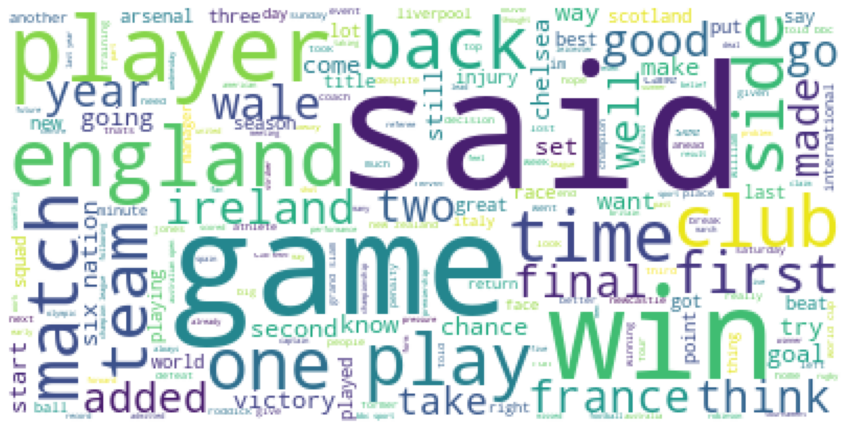

In [81]:

plt.figure(figsize=(15,15))
wordcloud = WordCloud(background_color="white").generate(' '.join(list(sport['Texts'])))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [84]:

semantics_analysis(sport)


,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining,Polarity Score
0,london hope chepkemei london marathon organise...,7,87,56,12,2,2,0,0,0,0.000001
1,collins banned landmark case sprinter michelle...,17,189,149,11,10,2,1,3,0,-0.666666
2,offcolour gardener storm win britain jason gar...,21,239,165,11,1,7,1,0,0,0.750001
3,holmes secures comeback victory britain kelly ...,14,130,89,9,1,4,0,0,0,0.600001
4,greene set sight world title maurice greene ai...,23,208,141,9,6,3,2,0,0,-0.333332


In [85]:

polarity_score(sport)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining,Polarity Score
0,london hope chepkemei london marathon organise...,7,87,56,12,2,2,0,0,0,0.000001
1,collins banned landmark case sprinter michelle...,17,189,149,11,10,2,1,3,0,-0.666666
2,offcolour gardener storm win britain jason gar...,21,239,165,11,1,7,1,0,0,0.750001
3,holmes secures comeback victory britain kelly ...,14,130,89,9,1,4,0,0,0,0.600001
4,greene set sight world title maurice greene ai...,23,208,141,9,6,3,2,0,0,-0.333332


##**ANALYSIS OF TECHNOLOGY ARTICLES**

In [87]:
tech = pd.DataFrame({'Texts': tech_text})
tech.head()

tech['Texts']= text_processing(tech['Texts'])

number_of_sentences(tech)

tech['Number of sentences'].nlargest(15)

remove_punctuation(tech)

number_of_words(tech)

count_complex_words(tech)

average_len_sentence(tech)

lemmatize(tech)

words_count_tech = words_count(tech)
words_count_tech[1:30]

,Words,Frequency
8103,people,960
6525,game,720
2978,technology,617
347,mobile,585
57,phone,539
3718,also,537
9834,one,519
9761,new,517
897,service,512
4759,mr,510


In [88]:

px.bar(words_count_tech[1:100],'Words','Frequency')



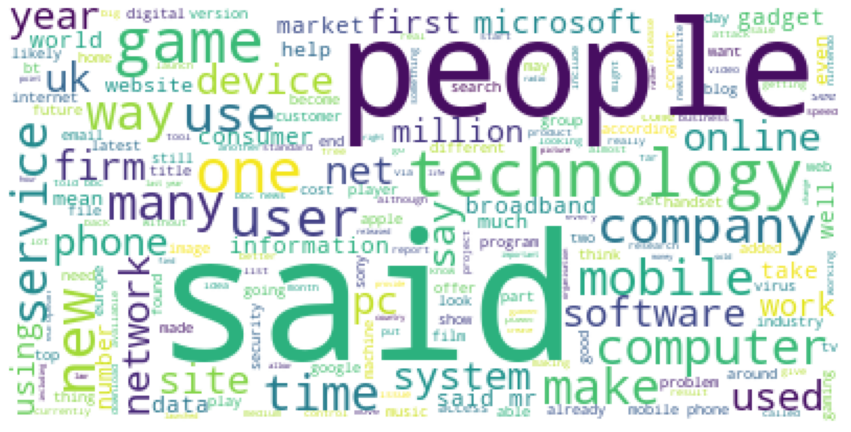

In [89]:
plt.figure(figsize=(15,15))
wordcloud = WordCloud(background_color="white").generate(' '.join(list(tech['Texts'])))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [90]:

semantics_analysis(tech)


,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining
0,solution net security fear fake bank email phi...,46,500,345,10,12,7,5,1,1
1,reboot ordered eu patent law european parliame...,14,181,143,12,9,4,2,3,2
2,sun offer processing hour sun microsystems lau...,15,175,117,11,2,0,1,0,1
3,microsoft release bumper patch microsoft warne...,15,174,136,11,8,0,1,0,0
4,apple laptop greatest gadget apple powerbook 1...,89,716,501,8,7,12,4,0,0


In [91]:
polarity_score(tech)

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining,Polarity Score
0,solution net security fear fake bank email phi...,46,500,345,10,12,7,5,1,1,-0.263157
1,reboot ordered eu patent law european parliame...,14,181,143,12,9,4,2,3,2,-0.384614
2,sun offer processing hour sun microsystems lau...,15,175,117,11,2,0,1,0,1,-0.999999
3,microsoft release bumper patch microsoft warne...,15,174,136,11,8,0,1,0,0,-0.999999
4,apple laptop greatest gadget apple powerbook 1...,89,716,501,8,7,12,4,0,0,0.263159


## **Analysis of all Articles**

In [96]:
all_articles = pd.concat([business,entertainment,tech,politics,sport])
all_articles.shape

(2225, 11)

In [100]:
all_articles.head()

,Texts,Number of sentences,Number of words,Number of Complex words,Average Length of sentence,Negative,Positive,Uncertainty,Litigious,Constraining,Polarity Score
0,air passenger win new eu right air passenger u...,28,363,280,12,20,5,4,3,3,-0.599999
1,call centre user lose patience customer trying...,29,377,256,13,13,4,5,0,0,-0.529411
2,job growth still slow u u created fewer job ex...,12,177,121,14,2,6,3,0,0,0.500001
3,yukos loses u bankruptcy battle judge dismisse...,23,267,206,11,21,3,4,8,2,-0.749999
4,high fuel price hit ba profit british airway b...,19,269,173,14,4,6,2,0,0,0.200001


In [97]:
words_count_articles = words_count(all_articles)

In [101]:
words_count_articles[1:50]

,Words,Frequency
10961,mr,3045
5480,year,2830
3127,would,2577
10259,also,2156
20799,people,2044
29707,new,1970
2217,u,1910
21951,one,1809
6014,could,1510
19751,game,1471


In [98]:

px.bar(words_count_articles[1:100],'Words','Frequency')



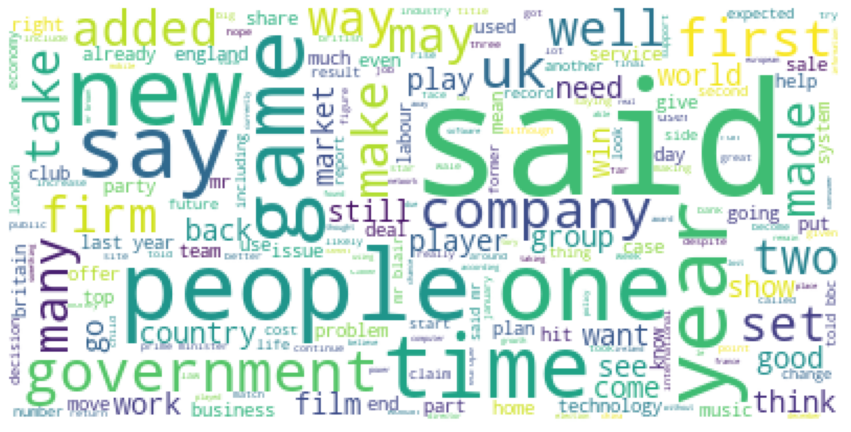

In [99]:
plt.figure(figsize=(15,15))
wordcloud = WordCloud(background_color="white").generate(' '.join(list(all_articles['Texts'])))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


##**TF-IDF Vectorization**

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [127]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(all_articles['Texts'])

In [129]:
X.shape

(2225, 30358)


##**KMEANS CLUSTERING**

In [130]:
from sklearn.cluster import KMeans

In [108]:
wcss =[]
for i in range(1, 11): 
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans.fit(X) 
  wcss.append(kmeans.inertia_)

**WCSS** is sum of squares of the distances of each data point in all clusters to their respective centroids

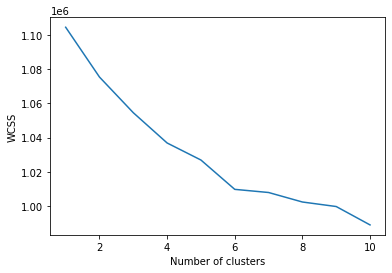

In [109]:
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

The Elbow is starting at 6. But we have 5 topics. So we're constrained to this.

In [132]:
kmeans = KMeans(n_clusters = 5, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit_predict(X)

In [139]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(5):
    print("\n Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:

 Cluster 0:
 mr
 labour
 election
 party
 blair
 tory
 said
 brown
 tax
 howard
 government
 minister
 lord
 prime
 chancellor
 conservative
 leader
 lib
 say
 plan

 Cluster 1:
 game
 england
 player
 win
 match
 said
 cup
 team
 injury
 champion
 play
 club
 wale
 season
 ireland
 world
 rugby
 coach
 chelsea
 final

 Cluster 2:
 said
 year
 mr
 company
 firm
 bank
 sale
 government
 market
 new
 growth
 economy
 price
 share
 rate
 country
 uk
 oil
 2004
 economic

 Cluster 3:
 film
 award
 best
 oscar
 actor
 star
 festival
 actress
 director
 nomination
 movie
 year
 comedy
 prize
 category
 aviator
 ceremony
 hollywood
 said
 role

 Cluster 4:
 mobile
 phone
 people
 technology
 user
 said
 service
 music
 digital
 net
 broadband
 software
 site
 computer
 game
 device
 network
 gadget
 microsoft
 pc


From above we can completely deduce that 
* **CLUSTER 0** is Political Articles
* **CLUSTER 1** is Sports Articles
* **CLUSTER 2** is Business Articles
* **CLUSTER 3** is Entertainment Articles
* **CLUSTER 0** is Tech Articles

##**LATENT DIRICHLET ALLOCATION**

In [140]:
!pip install pyLDAvis==3.2.1

     |████████████████████████████████| 1.7MB 5.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136187 sha256=fada38cd606680b4bcad0df526bd9fa64f9de059622168c0a6eba8291ce809dc
  Stored in directory: /root/.cache/pip/wheels/2f/cc/af/144c01e23fff8c11ef26e2fa161d98b7c2ae8c9a4f5cc48c2e
Successfully built pyLDAvis


In [142]:
import pyLDAvis
import pyLDAvis.gensim 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)